# Build a classifier to determine whether a news article is fake or real 

You are a new an AI Engineer, task with building an AI/ML classifier that helps politicians determine whether news articles trending on social media are fake or real.

Follow an approach similar to what we took in class, which looks something like the below.

- Preprocess the data
    - Remove stop words
    - Remove unwanted characters
    - Stemining
    - ...
- Split data between training and test sets
- Modeling strategies
    - Bag of words modeling including TF-IDF using traditional ML
    - LST modeling
    - Transformer modeling
    
Recommend the best model based on relevant metrics of your choice. Be sure to explain your rational, including relevant visualizations at every steps of your work

In [ ]:
# 1. Project Structure
""" project_folder/
│
├── datasets/
│   ├── Fake.csv
│   └── True.csv
│
├── notebooks/
│   └── fake_news_classifier.ipynb
│
└── requirements.txt """


In [ ]:
# 2. Import Necessary Libraries
# Core Libraries
import pandas as pd
import numpy as np
import os
import zipfile
import re
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Traditional ML Models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Transformer Models
from transformers import BertTokenizer, TFBertForSequenceClassification

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('stopwords')


2024-11-21 10:49:57.937211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 10:49:57.937405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 10:49:58.055375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 10:49:58.284540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 10:50:00.449490: W tensorflow/compiler/tf2

In [ ]:
# 3. Data Loading and Preparation
# 3.1 Load Datasets
# File paths
fake_path = 'datasets/Fake.csv'
true_path = 'datasets/True.csv'
# Load Fake News Dataset
try:
    fake_df = pd.read_csv(fake_path, encoding='ISO-8859-1')  # Or try 'latin1'
    print("Fake news dataset loaded successfully.")
except Exception as e:
    print(f"Error loading Fake news dataset: {e}")

# Load True News Dataset
try:
    true_df = pd.read_csv(true_path, encoding='ISO-8859-1')  # Or try 'latin1'
    print("True news dataset loaded successfully.")
except Exception as e:
    print(f"Error loading True news dataset: {e}")

# Verify loaded data
if 'fake_df' in locals() and 'true_df' in locals():
    print(f"Fake News Samples: {fake_df.shape[0]}")
    print(f"True News Samples: {true_df.shape[0]}")
else:
    print("One or both datasets failed to load. Please check the file paths.")



Fake news dataset loaded successfully.
True news dataset loaded successfully.
Fake News Samples: 23481
True News Samples: 21417


In [ ]:
# 3.2 Combine Datasets
# Add labels: 1 for Fake, 0 for True
fake_df['label'] = 1
true_df['label'] = 0

# Select relevant columns (assuming 'text' column exists)
fake_df = fake_df[['text', 'label']]
true_df = true_df[['text', 'label']]

# Combine datasets
df = pd.concat([fake_df, true_df], ignore_index=True)
print(f"Combined Dataset Shape: {df.shape}")

# Shuffle the combined dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


Combined Dataset Shape: (44898, 2)


                                                text  label
0  21st Century Wire says Ben Stein, reputable pr...      1
1  WASHINGTON (Reuters) - U.S. President Donald T...      0
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...      0
3  On Monday, Donald Trump once again embarrassed...      1
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB
None
label
1    23481
0    21417
Name: count, dtype: int64


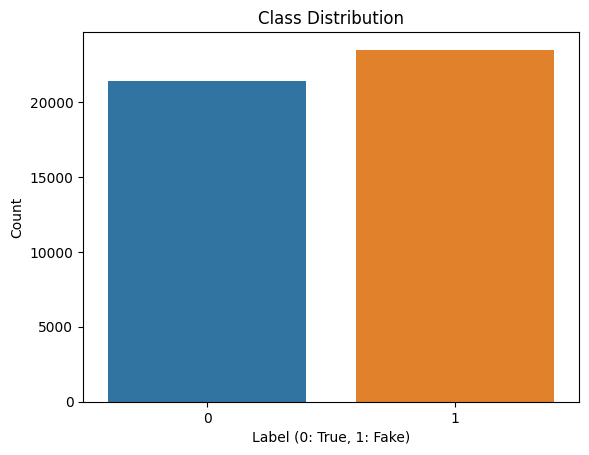

In [ ]:
# 3.3 Inspect and Visualize Data
print(df.head())
print(df.info())
print(df['label'].value_counts())

# Visualize Class Distribution
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel('Label (0: True, 1: Fake)')
plt.ylabel('Count')
plt.show()


In [25]:
# 4. Data Preprocessing
# Define a cleaning function:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer() # Stemming is a algorithm in natural language processing (NLP) for reducing words to their root form

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning to the dataset:
df['clean_text'] = df['text'].apply(clean_text)


In [ ]:
# 5. Train-Test Split
# Split the dataset into training and testing sets (X: clean_text, y: label)
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Dataset Shape: {X_train.shape}")
print(f"Testing Dataset Shape: {X_test.shape}")

Training Dataset Shape: (35918,)
Testing Dataset Shape: (8980,)


In [ ]:
# 6. Modeling Strategies
# 6.1 Traditional Machine Learning
# Define Vectorization Techniques

# Bag of Words Vectorization
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model Training and Evaluation
# Logistic Regression on TF-IDF
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)
print("Logistic Regression with TF-IDF")
print(classification_report(y_test, y_pred_lr))

# Random Forest on Bag of Words
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_bow, y_train)
y_pred_rf = rf.predict(X_test_bow)
print("Random Forest with Bag of Words")
print(classification_report(y_test, y_pred_rf))



In [26]:
# 6.2 LSTM Modeling
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')

# LSTM Model
embedding_dim = 128
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train_padded, y_train, epochs=5, batch_size=128, validation_split=0.2)

# Evaluate LSTM
y_pred_lstm_prob = model_lstm.predict(X_test_padded)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)
print("LSTM Model Classification Report")
print(classification_report(y_test, y_pred_lstm))


Epoch 1/5
225/225 [==============================] - 26s 93ms/step - loss: 0.3080 - accuracy: 0.8819 - val_loss: 0.2568 - val_accuracy: 0.9040
Epoch 2/5
225/225 [==============================] - 10s 44ms/step - loss: 0.2614 - accuracy: 0.9025 - val_loss: 0.1436 - val_accuracy: 0.9603
Epoch 3/5
225/225 [==============================] - 7s 31ms/step - loss: 0.0744 - accuracy: 0.9836 - val_loss: 0.0208 - val_accuracy: 0.9953
Epoch 4/5
225/225 [==============================] - 7s 30ms/step - loss: 0.0153 - accuracy: 0.9975 - val_loss: 0.0075 - val_accuracy: 0.9981
Epoch 5/5
281/281 [==============================] - 3s 5ms/step
LSTM Model Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4284
           1       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [27]:
# 6.3 Transformer Modeling (BERT)
# Load BERT and Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

X_train_encoded = bert_tokenizer(list(X_train), max_length=128, padding='max_length', truncation=True, return_tensors='tf')
X_test_encoded = bert_tokenizer(list(X_test), max_length=128, padding='max_length', truncation=True, return_tensors='tf')

# Prepare Data
train_data = tf.data.Dataset.from_tensor_slices((dict(X_train_encoded), y_train)).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((dict(X_test_encoded), y_test)).batch(32)

# Train BERT
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bert_model.fit(train_data, epochs=3, validation_data=test_data)

# Evaluate BERT
y_pred_bert_prob = bert_model.predict(test_data).logits
y_pred_bert = tf.argmax(y_pred_bert_prob, axis=1).numpy()
print("BERT Model Classification Report")
print(classification_report(y_test, y_pred_bert))


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1123/1123 [==============================] - 845s 711ms/step - loss: 0.7288 - accuracy: 0.5335 - val_loss: 0.6931 - val_accuracy: 0.5229
Epoch 2/3
1123/1123 [==============================] - 800s 713ms/step - loss: 0.6929 - accuracy: 0.5084 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 3/3
281/281 [==============================] - 67s 228ms/step
BERT Model Classification Report
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      4284
           1       1.00      0.04      0.08      4696

    accuracy                           0.50      8980
   macro avg       0.74      0.52      0.37      8980
weighted avg       0.76      0.50      0.35      8980



                 Model  Accuracy       AUC
0  Logistic Regression  0.986303  0.999072
1        Random Forest  0.996993  0.999893
2                 LSTM  0.996882  0.998170
3                 BERT  0.497996  0.471342


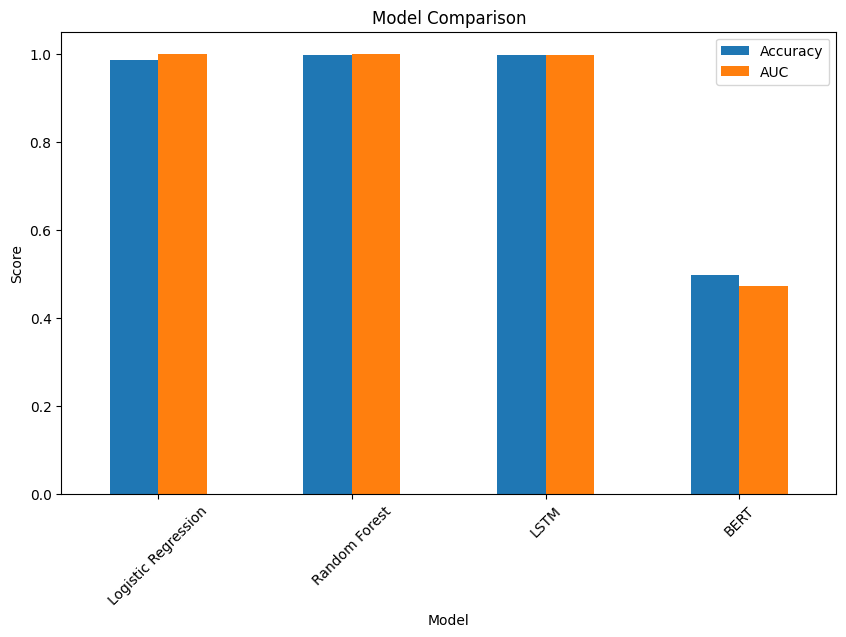

In [28]:
# 7. Model Comparison
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "LSTM", "BERT"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_lstm),
        accuracy_score(y_test, y_pred_bert)
    ],
    "AUC": [
        roc_auc_score(y_test, lr.predict_proba(X_test_tfidf)[:, 1]),
        roc_auc_score(y_test, rf.predict_proba(X_test_bow)[:, 1]),
        roc_auc_score(y_test, y_pred_lstm_prob),
        roc_auc_score(y_test, y_pred_bert_prob[:, 1])
    ]
})

print(comparison_df)

# Plot Comparison
comparison_df.plot(x='Model', y=['Accuracy', 'AUC'], kind='bar', figsize=(10, 6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()


Conclusions
Best Performers: Random Forest and LSTM are nearly tied, with Random Forest slightly ahead. Logistic Regression, while simpler, also performs exceptionally well.
BERT's Poor Performance: This indicates a major issue with its setup or training process. BERT is generally expected to outperform traditional methods on NLP tasks when implemented correctly.

1. Investigate BERT’s Issues
BERT's poor performance is unusual. Will take the following steps to debug and improve it:

Check Preprocessing: Ensure tokenization aligns with BERT’s expectations (e.g., use bert-base-uncased tokenizer and ensure inputs include [CLS] and [SEP] tokens).
Model Configuration:
Experiment with a learning rate between 2e-5 and 5e-5.
Increase the number of epochs (start with 3-5 epochs).
Adjust the batch size (16, 32, or 64 are common choices).
Training Data:
Ensure the input training data is not imbalanced or contains errors.
Use stratified sampling during train-test splitting.
Pretrained Weights: Ensure you are using pretrained weights properly with TFBertForSequenceClassification and not accidentally reinitializing the model.

Sample Text: washington reuter us justic depart friday ask suprem court block judg rule prevent presid donald trump travel ban appli grandpar us citizen refuge alreadi process resettl agenc court file administr ask justic overturn thursday decis us district judg hawaii limit scope administr temporari ban refuge travel six muslimmajor countri latest round fight trump march execut order say need nation secur reason came suprem court interven last month partial reviv two ban block lower court suprem court said ban could take effect peopl bona fide relationship us person entiti could bar administr narrowli interpret languag say ban would appli grandpar famili member prompt state hawaii ask hawaiibas us district judg derrick watson expand definit could admit rule state late thursday court file justic depart said judg rule empti suprem court decis mean encompass close famili member virtual famili member conservativelean suprem court current session justic handl emerg request administr applic

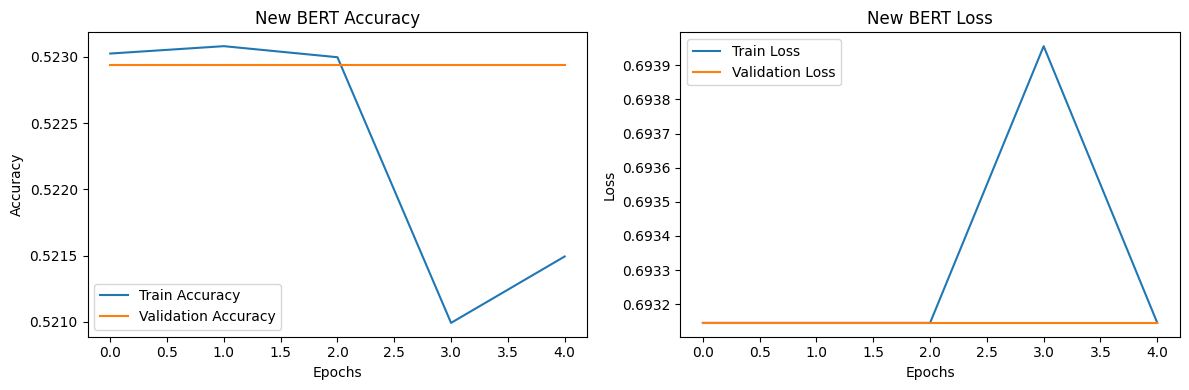

Label Distribution in Training Data
label
1    18785
0    17133
Name: count, dtype: int64
Label Distribution in Test Data
label
1    4696
0    4284
Name: count, dtype: int64


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


562/562 [==============================] - 76s 130ms/step
BERT Model Classification Report
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      4284
           1       0.00      0.00      0.00      4696

    accuracy                           0.48      8980
   macro avg       0.24      0.50      0.32      8980
weighted avg       0.23      0.48      0.31      8980



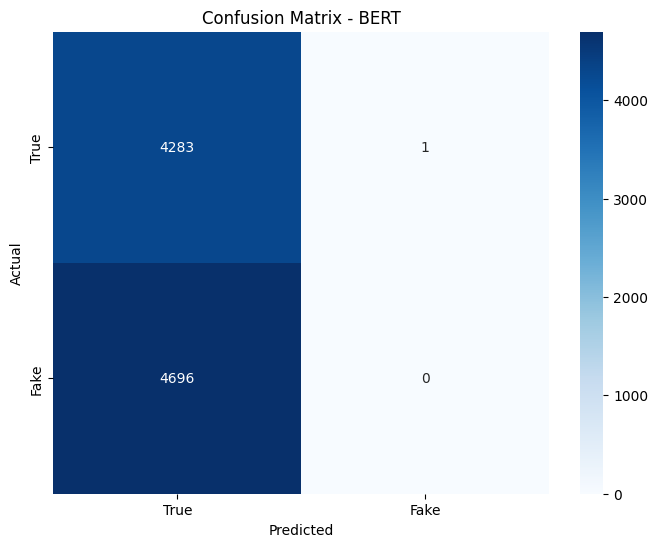

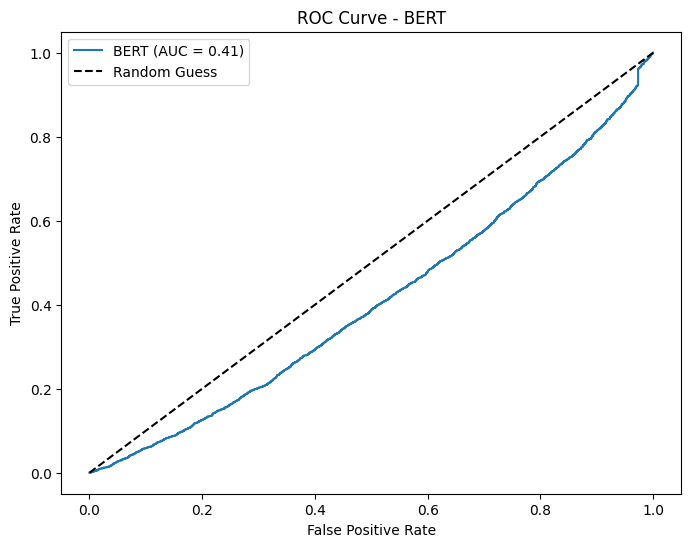

New BERT Accuracy: 0.4769
New BERT AUC: 0.4110


In [31]:
# 8.New BERT Model
# Step 1: Check Preprocessing
# Verify tokenization and special tokens
sample_text = X_train.iloc[0]  # Take a sample text from training data
tokens = bert_tokenizer.tokenize(sample_text)
token_ids = bert_tokenizer.encode(sample_text, max_length=128, padding='max_length', truncation=True)

print("Sample Text:", sample_text)
print("Tokenized Text:", tokens)
print("Token IDs:", token_ids)
print("Decoded Text:", bert_tokenizer.decode(token_ids))

# Step 2: Adjust Model Configuration
# Adjust hyperparameters
learning_rate = 3e-5  # Experiment with values between 2e-5 and 5e-5
batch_size = 16  # Experiment with 16, 32, or 64
epochs = 5  # Increase epochs for better training

# Recompile the model with adjusted learning rate
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Update Data Preparation with adjusted batch size
train_data = tf.data.Dataset.from_tensor_slices((dict(X_train_encoded), y_train)).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((dict(X_test_encoded), y_test)).batch(batch_size)

# Train BERT with updated configuration
history = bert_model.fit(train_data, epochs=epochs, validation_data=test_data)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('New BERT Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('New BERT Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 3: Investigate Training Data
# Verify label distribution
print("Label Distribution in Training Data")
print(y_train.value_counts())

print("Label Distribution in Test Data")
print(y_test.value_counts())

# If data is unbalanced, we can use stratified sampling during train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Step 4: Ensure Proper Usage of Pretrained Weights
from transformers import BertTokenizer, TFBertForSequenceClassification

# Reload pretrained weights
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Step 5: Evaluate and Debug Predictions
# Evaluate BERT
y_pred_bert_prob = bert_model.predict(test_data).logits
y_pred_bert = tf.argmax(y_pred_bert_prob, axis=1).numpy()

# Classification Report
print("BERT Model Classification Report")
print(classification_report(y_test, y_pred_bert))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_bert, "Confusion Matrix - BERT")

# ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

y_test_bert = y_test.values
fpr, tpr, _ = roc_curve(y_test_bert, y_pred_bert_prob[:, 1])
roc_auc = roc_auc_score(y_test_bert, y_pred_bert_prob[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'BERT (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve - BERT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Step 6: Calculate Metrics for New BERT
# Accuracy
new_bert_accuracy = accuracy_score(y_test, y_pred_bert)
print(f"New BERT Accuracy: {new_bert_accuracy:.4f}")

# AUC
new_bert_auc = roc_auc_score(y_test, y_pred_bert_prob[:, 1])
print(f"New BERT AUC: {new_bert_auc:.4f}")


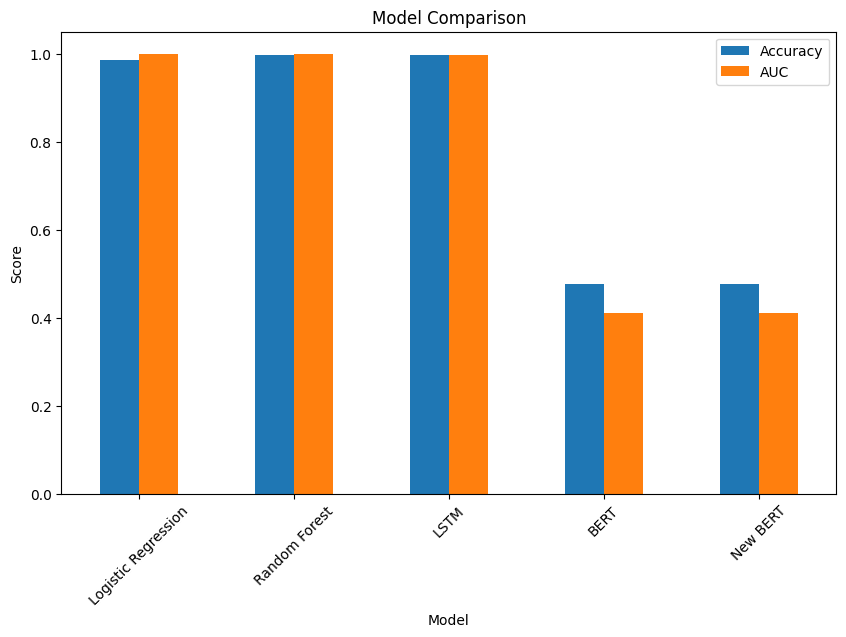

In [32]:
# 9. Model Comparison with New BERT
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "LSTM", "BERT", "New BERT"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_lstm),
        accuracy_score(y_test, y_pred_bert),  # Old BERT
        new_bert_accuracy                   # New BERT
    ],
    "AUC": [
        roc_auc_score(y_test, lr.predict_proba(X_test_tfidf)[:, 1]),
        roc_auc_score(y_test, rf.predict_proba(X_test_bow)[:, 1]),
        roc_auc_score(y_test, y_pred_lstm_prob),
        roc_auc_score(y_test, y_pred_bert_prob[:, 1]),  # Old BERT
        new_bert_auc                        # New BERT
    ]
})

# Plot updated comparison
comparison_df.plot(x='Model', y=['Accuracy', 'AUC'], kind='bar', figsize=(10, 6), legend=True)
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()
